In [1]:
# Python 3.7
# author: Leonardo Filipe
# website: https://www.leonardofilipe.com
# contact: contact[at]leonardofilipe.com
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as interp

plt.style.use('seaborn')
pd.options.mode.chained_assignment = None

db = pd.read_hdf("moreoptiondata.h5")
db['Now'] = pd.to_datetime(db['Now'])
db['Maturity'] = pd.to_datetime(db['Maturity'])

In [2]:
N0 = db[db['Now'] == '2018-05-28 14:50:00']
M0 = N0[N0['Maturity'] == '2018-06-15 17:30:00']
M0[M0['CallImpVol'] < 0.001] = 0
M0 = M0.loc[(M0!=0).any(1)]
M0 = M0.reset_index().drop('index',axis=1)
M0['Moneyness'] = abs(M0['Strike']/M0['Spot'])

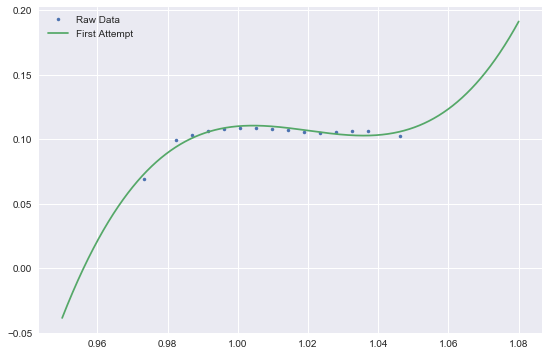

In [3]:
p = np.poly1d(np.polyfit(M0['Moneyness'], M0['CallImpVol'], 3))

xp = np.linspace(0.95, 1.08, 4310)

plt.figure(figsize=(9,6))
plt.plot(M0['Moneyness'], M0['CallImpVol'], '.', label='Raw Data')
plt.plot(xp, p(xp), '-', label='First Attempt')
plt.legend()
plt.show()

In [4]:
M0 = db[db['Maturity'] == '2018-06-15 17:30:00']
M0[M0['CallImpVol'] < 0.001] = 0
M0 = M0.loc[(M0!=0).any(1)]
M0 = M0.reset_index().drop('index',axis=1)
M0['Moneyness'] = abs(M0['Strike']/M0['Spot'])

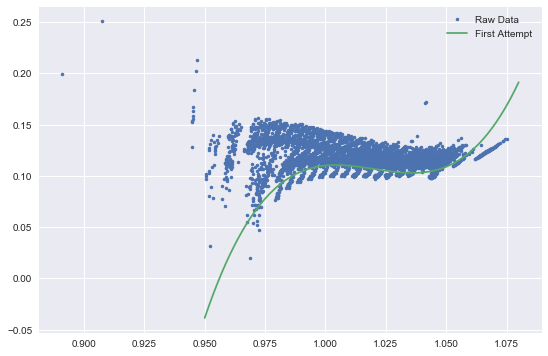

In [5]:
plt.figure(figsize=(9,6))
plt.plot(M0['Moneyness'], M0['CallImpVol'], '.', label='Raw Data')
plt.plot(xp, p(xp), '-', label='First Attempt')
plt.legend()
plt.show()

In [6]:
zfun_smooth_rbf = interp.Rbf(M0['Moneyness'], M0['Expiration'], M0['CallImpVol'], function='cubic', smooth=0)
z_dense_smooth_rbf = zfun_smooth_rbf(M0['Moneyness'], M0['Expiration'])

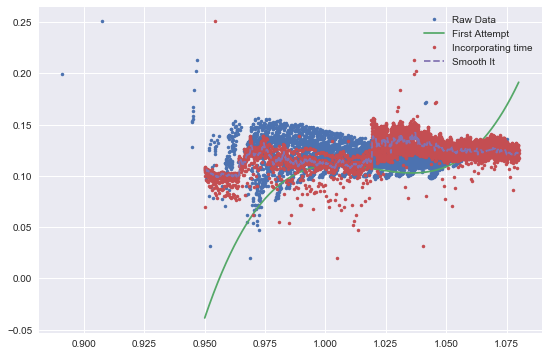

In [7]:
plt.figure(figsize=(9,6))
plt.plot(M0['Moneyness'], M0['CallImpVol'], '.', label='Raw Data')
plt.plot(xp, p(xp), '-', label='First Attempt')
plt.plot(xp, z_dense_smooth_rbf, '.', label='Incorporating time')
plt.plot(xp, pd.Series(z_dense_smooth_rbf).rolling(window=20).median(), '--', label='Smooth It')
plt.legend()
plt.show()